In [1]:
import numpy as np, matplotlib.pyplot as plt
from importlib import reload
import os, time, shutil, sys
from inputs import  Inputs
from pathlib import Path
notebook_dir = Path(os.getcwd())
sys.path.append(str(notebook_dir.parent))
import data, pipelines, utils, net, infer  


if not os.path.exists('figs'):
    os.mkdir('figs')
if not os.path.exists('ckpts'):
    os.mkdir('ckpts')

/home/ron/neural-fitting/utils.py:444: SyntaxWarning: invalid escape sequence '\ '
  string += f"f_{{ss}}={tmp.mean():.2f}\\pm{tmp.std():.2f}\ (\%),\ "
/home/ron/neural-fitting/utils.py:448: SyntaxWarning: invalid escape sequence '\ '
  string += f"k_{{ss}}={tmp.mean():.1f}\\pm{tmp.std():.1f}\ (s^{{-1}}),\ "
/home/ron/neural-fitting/utils.py:448: SyntaxWarning: invalid escape sequence '\ '
  string += f"k_{{ss}}={tmp.mean():.1f}\\pm{tmp.std():.1f}\ (s^{{-1}}),\ "
/home/ron/neural-fitting/utils.py:452: SyntaxWarning: invalid escape sequence '\ '
  string += f"f_{{s}}={tmp.mean():.2f}\\pm{tmp.std():.2f}\ (\%),\ "
/home/ron/neural-fitting/utils.py:456: SyntaxWarning: invalid escape sequence '\ '
  string += f"k_{{s}}={tmp.mean():.1f}\\pm{tmp.std():.1f}\ (s^{{-1}})"


### Creating setup & inspecting the data

As a public sample, we use a "virtual brain" dataset of 4 virtual slices, one from each of the healthy volunteers studied.

This dataset comprised of auxiliary T1,T2,B0,B1 maps and MT, Amide raw data as well as T1-based WM/GM masks are stored together in a xarray-based single-file serialization.


In [2]:
sample = True  # [internal] uncomment to use a single-subject full-brain dataset (e.g. "volunteer 8" used in paper)
inpt = Inputs(Path('/home/ron/pediatric-tumor-mice/Pediatric tumor model_Nov2024/20241120_134917_OrPerlman_ped_tumor_immuno_C3_2R_5_1_3'), "C3_2R_2024-11-20")
data_xa = inpt.dataset
data_feed_mt = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='mt',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)
data_feed_amide = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='amide',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)

In [3]:
data_xa

<xarray.Dataset> Size: 2MB
Dimensions:            (height: 64, slice: 1, width: 64, MRF_cycles: 31)
Dimensions without coordinates: height, slice, width, MRF_cycles
Data variables:
    roi_mask_nans      (height, slice, width) float64 33kB nan nan ... nan nan
    B1_fix_factor_map  (height, slice, width) float64 33kB 144.0 215.0 ... 248.0
    B0_shift_ppm_map   (height, slice, width) float64 33kB 77.0 78.0 ... 91.0
    T2ms               (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    T1ms               (height, slice, width) float64 33kB 1.388e+03 0.0 ... 0.0
    MT_data            (MRF_cycles, height, slice, width) float64 1MB 86.0 .....
    AMIDE_data         (MRF_cycles, height, slice, width) float64 1MB 122.0 ....

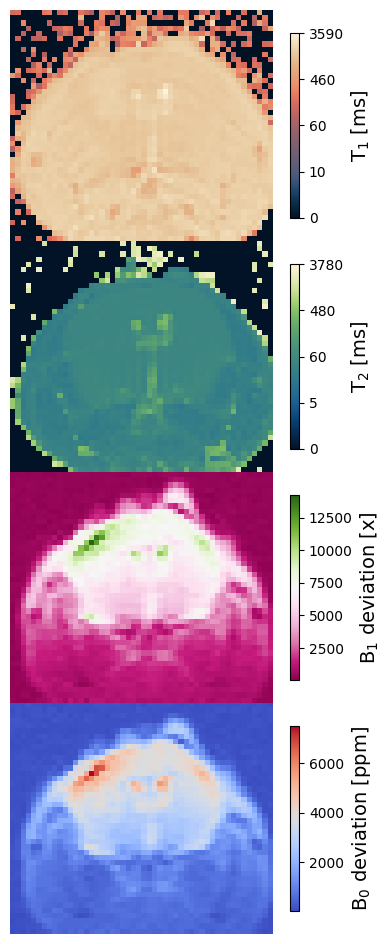

In [4]:
reload(utils)

utils.viz_t1t2b0b1_sample_slices(data_xa, data_feed_mt, sample=sample)


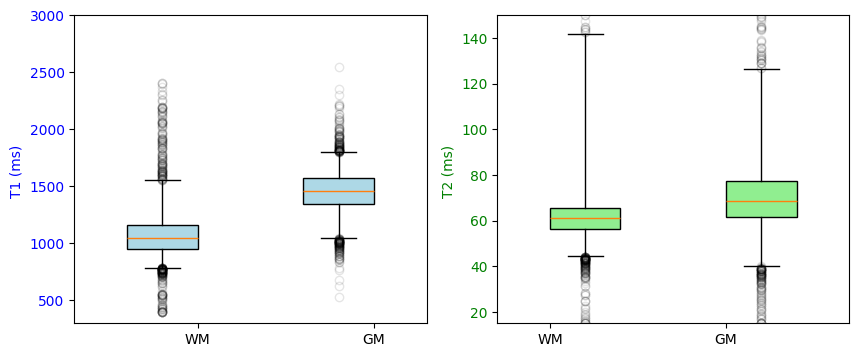

In [5]:
import utils
reload(utils)

utils.GMWM_T1T2_boxplot(data_xa)

### Solving the inverse problem using NBMF

In [12]:

do_train = True           # set to False to quickly reuse a checkpoint
sfx = 'sample' if sample else 'brain'
ckpts = os.path.abspath(f'./ckpts/{sfx}')  # edit for custom flows..

if sample: 
    pipelines.pipeline_config.mt_train_slw = 2               # quicker compile..?
    pipelines.pipeline_config.mt_patience = 100              # ensure convergence? 
    pipelines.pipeline_config.amide_patience = 20            # ensure convergence?
    # Augmentation by learnt-covariance noise: set to True for more robust training (across attempts/datasets),
    # but somewhat noisier maps - especially for the small sample dataset
    pipelines.pipeline_config.train_config.tp_noise = True  

if do_train:
    shutil.rmtree(f'{ckpts}/mt', ignore_errors=True)
    shutil.rmtree(f'{ckpts}/amide', ignore_errors=True)
    predictor_mt, predictor_amide = pipelines.run_train(
        brain2train_mt=data_feed_mt, 
        brain2train_amide=data_feed_amide, 
        ckpt_folder=ckpts,
        mt_sim_mode='expm_bmmat'
        )
    # NOTE - early stopping of training can be also triggered manually by simply sending interrupt to the kernel.
    #        creation and checkpointing of the neural reconstructor will go on normally, using the weights at the moment.
else:  
    predictor_mt = net.load_ckpt(folder=f'{ckpts}/mt')[0]
    predictor_amide = net.load_ckpt(folder=f'{ckpts}/amide')[0]
    infer.infer_config = pipelines.pipeline_config.infer_config  
    # ..ideally, should be stored alongside checkpoint & used to ensure train/test consistency
    #   in pre/post-processing (i.e. network's outputs' interpretation..)

epochs = 1000
effective epochs = 1000


  0%|                                                                                                                       | 0/2000 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
loss_total = 2.37,signal reconstruction error (%) = 2.94 (MA: 3.18):  44%|█████████████████▋                      | 882/2000 [02:20<02:58,  6.27it/s]


Met early stopping criteria, breaking at epoch 440


  0%|                                                                                                                          | 0/1 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


epochs = 500
effective epochs = 125


  0%|                                                                                                                       | 0/2000 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
loss_total = 3.05,signal reconstruction error (%) = 3.60 (MA: 3.47):  41%|████████████████▏                       | 811/2000 [13:29<19:46,  1.00it/s]


Training cut short by user request


#### Analyzing the resultant maps of tissue parameter estimates

  0%|                                                                                                                          | 0/1 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
  0%|                                                                                                                          | 0/2 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]
/home/alexf/neural-fitting/utils.py:575: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels(['1.00' if tick==1 else f"{tick:.3f}".lstrip('0') for tick in cax.get_yticks()])
/home/alexf/

GM: f=0.055799+-0.021211 , k=30.285730+-10.408047 
WM: f=0.087710+-0.046481 , k=27.575757+-8.313214 
-- concentration: -- 
white = 8.77+-4.65, 
gray: 5.58+-2.12
-- exchange-rate: -- 
white = 27.6+-8.3, 
gray: 30.3+-10.4
GM: f=0.001413+-0.000585 , k=194.843502+-62.575639 
WM: f=0.001847+-0.000922 , k=229.139477+-85.472998 
-- concentration: -- 
white = 0.18+-0.09, 
gray: 0.14+-0.06
-- exchange-rate: -- 
white = 229.1+-85.5, 
gray: 194.8+-62.6


/home/alexf/neural-fitting/utils.py:487: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(('WM', 'GM'), fontsize=15); plt.ylabel("$f_{ss}$ (%)" if pool=='MT' else "$f_{s}$ (%)", fontsize=15); #plt.ylim(0, 1)
/home/alexf/neural-fitting/utils.py:512: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(('WM', 'GM'), fontsize=15); plt.ylabel("$k_{ssw}$ $(s^{-1})$" if pool=='MT' else "$k_{sw}$ $(s^{-1})$", fontsize=15); #plt.ylim(0, 1)
/home/alexf/neural-fitting/utils.py:487: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(('WM', 'GM'), fontsize=15); plt.ylabel("$f_{ss}$ (%)" if pool=='MT' else "$f_{s}$ (%)", fontsize=15); #plt.ylim(0, 1)
/home/alexf/neural-fitting/utils.py:512

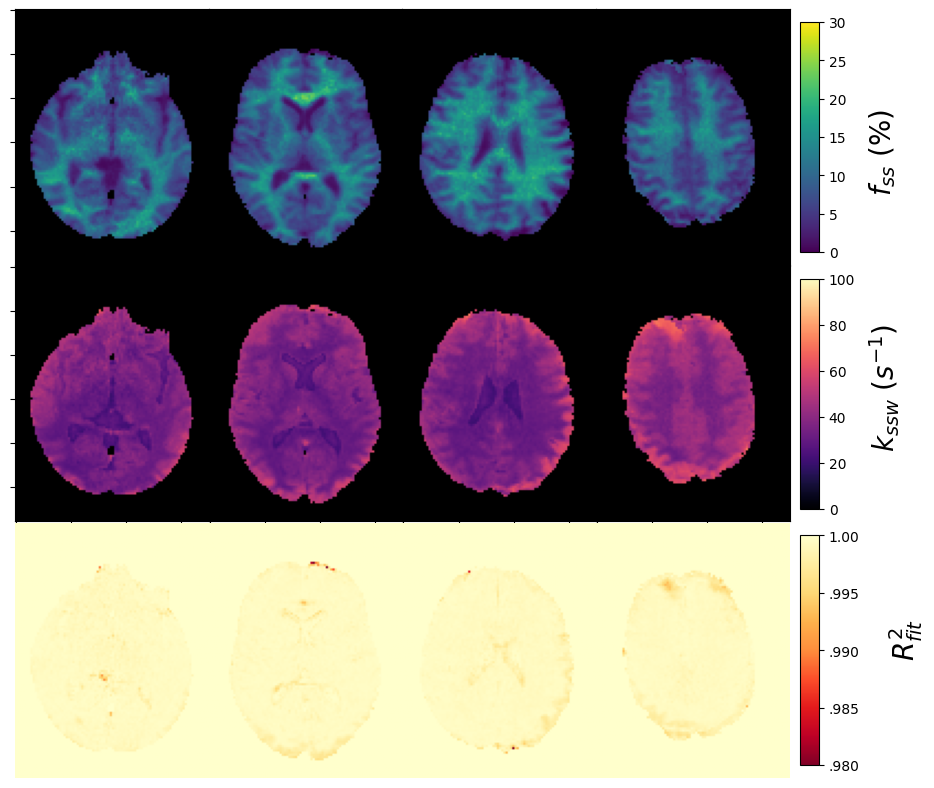

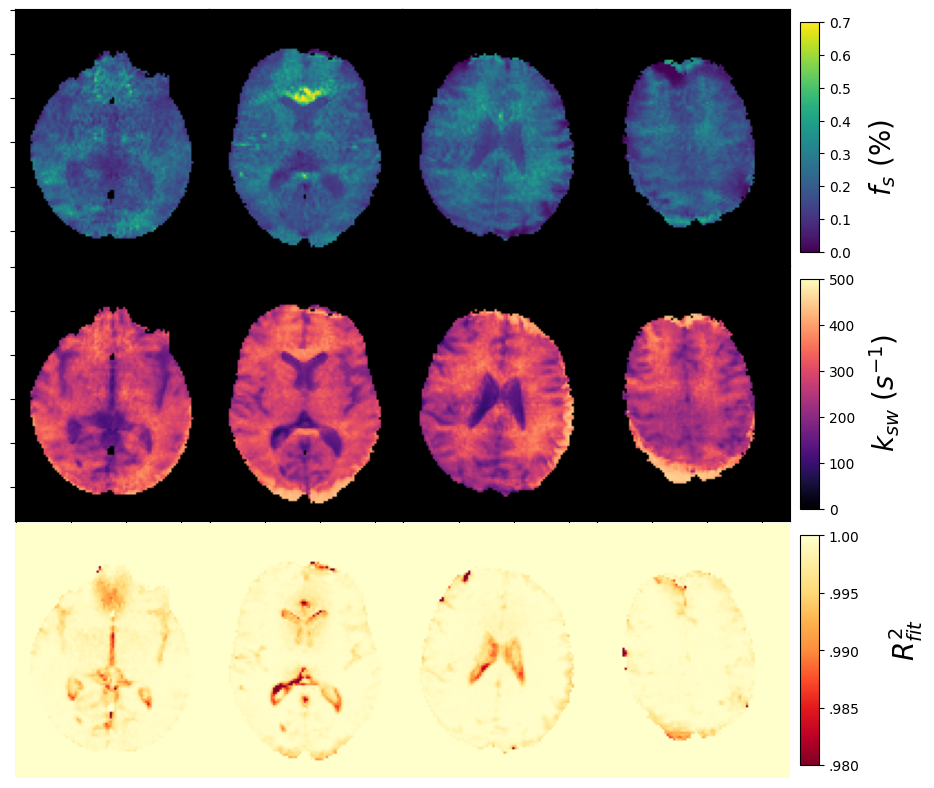

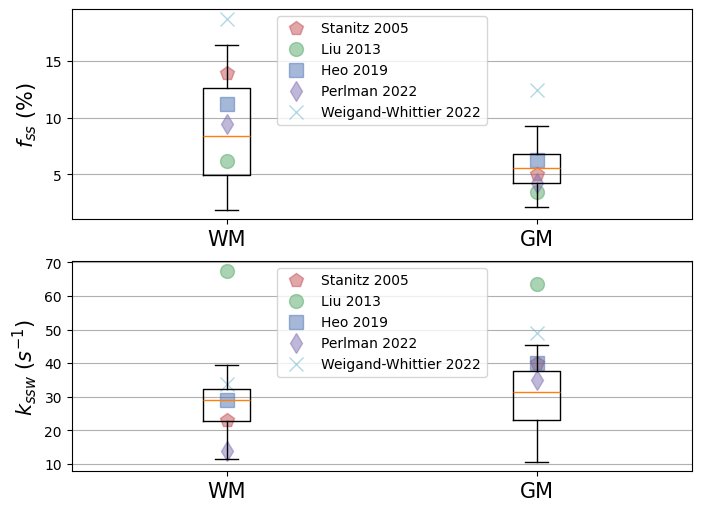

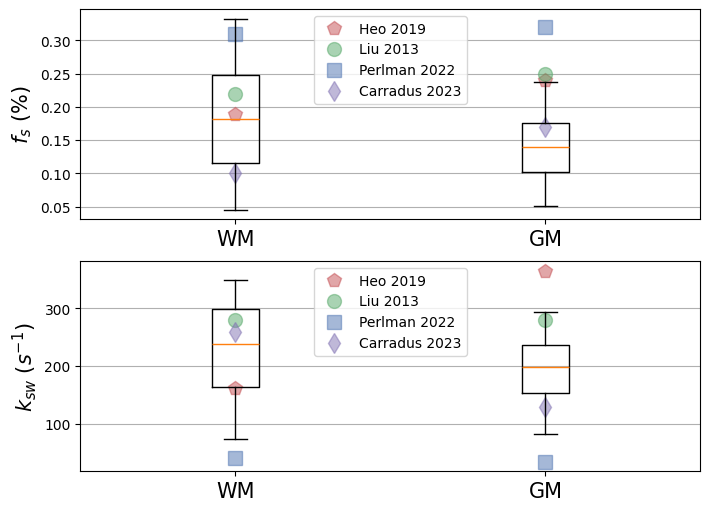

In [13]:
transfer_res, err_mt, err_amide = pipelines.transfer_and_plot(
    brain2test_mt=data_feed_mt, brain2test_amide=data_feed_amide, 
    predictor_mt=predictor_mt, predictor_amide=predictor_amide, 
    figsfolder='./figs', figsfx='mt', slices=range(data_feed_mt.shape[1]) if sample else None, 
    mask_gray=data_xa.gray_mask.values, mask_white=data_xa.white_mask.values,
    )

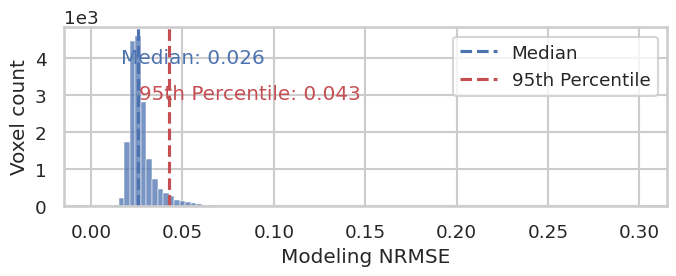

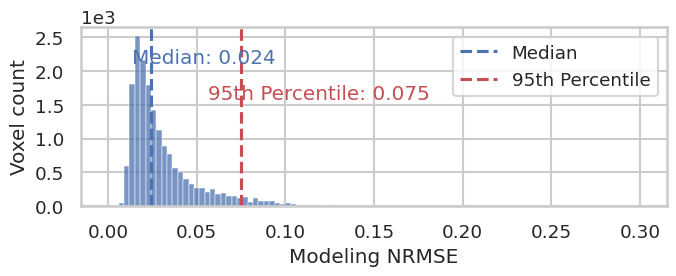

In [14]:
utils.fancy_histogram(err_mt)
utils.fancy_histogram(err_amide)

### Reference methods I: Purely voxelwise

Purely-voxelwise dictionary matching (aka dot-product, aka MRF), and per-voxel non-neural fitting (VBMF)

Demonstrated for MT, as in the Supplementary Figures 5, 6

#### Dictionary-matching

(Supplementary Figure 5)

In [9]:
from dictionary_methods import dictbased_runner; reload(dictbased_runner)

dict_as_slicefeed = dictbased_runner.get_dict() # lhs_size_x10k=200)
fss_pred_dict, kss_pred_dict, best_match, err_3d_dict = \
    dictbased_runner.match_to_dict(dict_as_slicefeed, data_feed_mt, constrain_T1T2=True) #, constrain_B0B1=True)
    

/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
  0%|                                                                                                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.90s/it]


0
1
2
3


/home/alexf/neural-fitting/utils.py:575: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels(['1.00' if tick==1 else f"{tick:.3f}".lstrip('0') for tick in cax.get_yticks()])


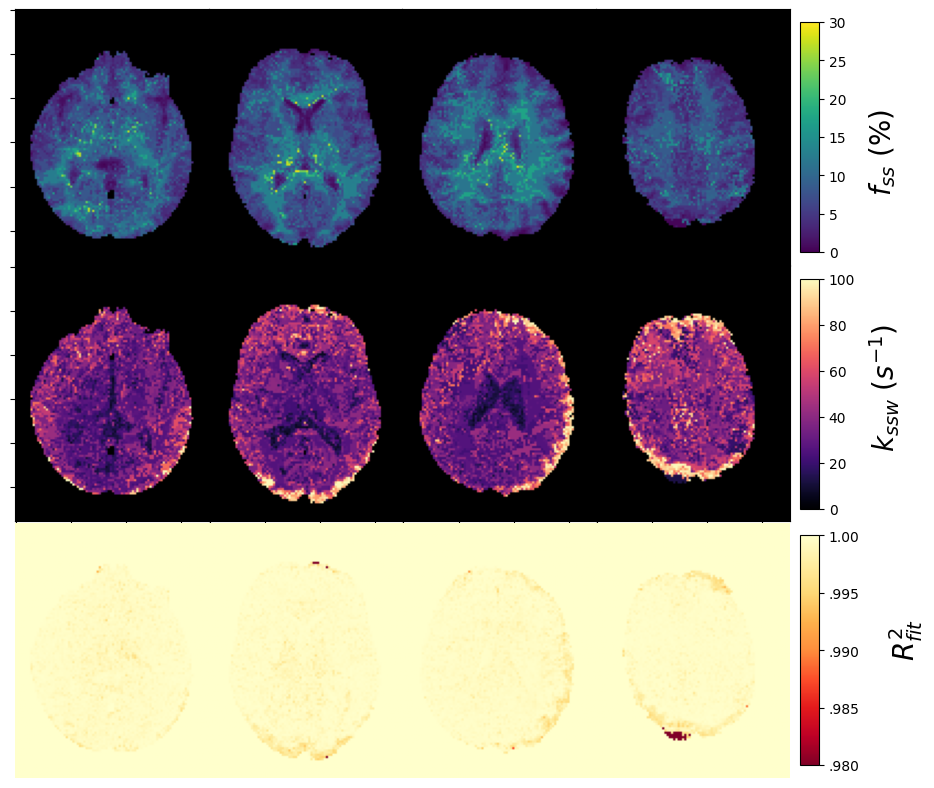

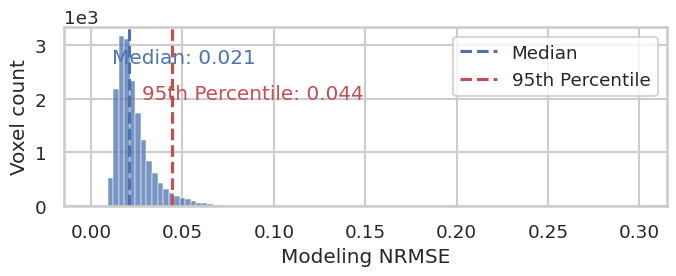

In [10]:
reload(utils)

utils.slice_row_plot(
    fss_pred_dict, kss_pred_dict, err_3d_dict, fss_lims=[0,30], kss_lims=[0,100],
    slices=range(data_feed_mt.shape[1]) if sample else None
)            
utils.fancy_histogram(err_3d_dict)

#### VBMF

(Supplementary Figure 6)

epochs = 1000
effective epochs = 1000


  0%|                                                                                                                                                                                                                                                                 | 0/2000 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)


loss_total = 3.08,signal reconstruction error (%) = 3.08 (MA: 3.23):  28%|█████████████████████████████████████████████████▊                                                                                                                                | 560/2000 [02:06<05:26,  4.41it/s]


Met early stopping criteria, breaking at epoch 279


  0%|                                                                                                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.78s/it]
/home/alexf/neural-fitting/utils.py:575: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels(['1.00' if tick==1 else f"{tick:.3f}".lstrip('0') for tick in cax.get_yticks()])


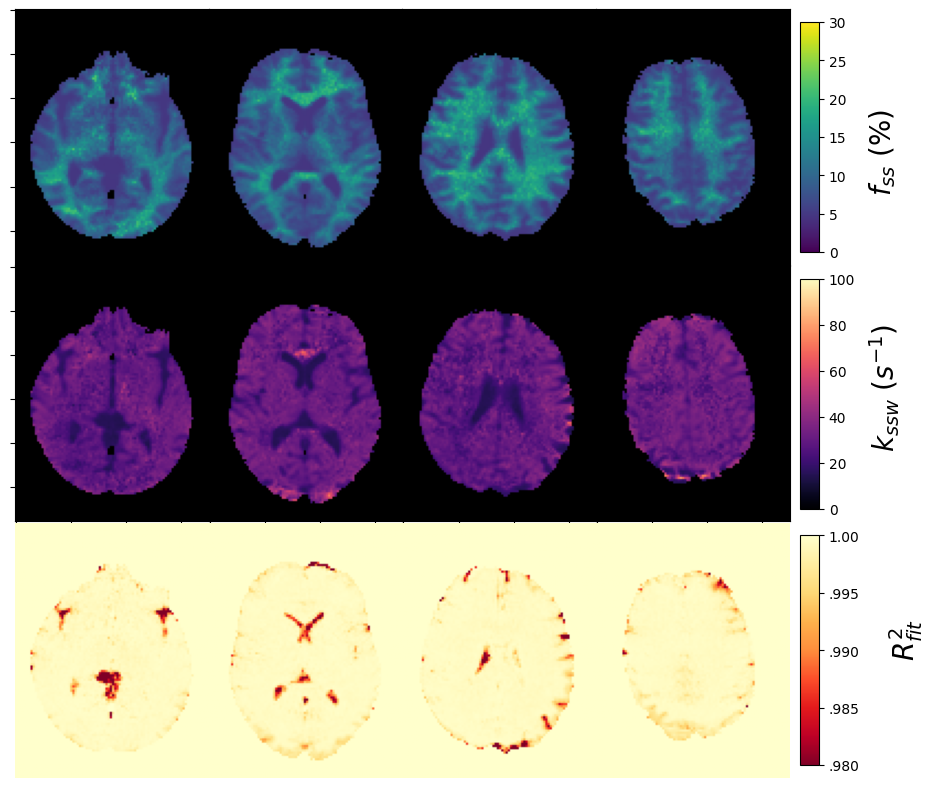

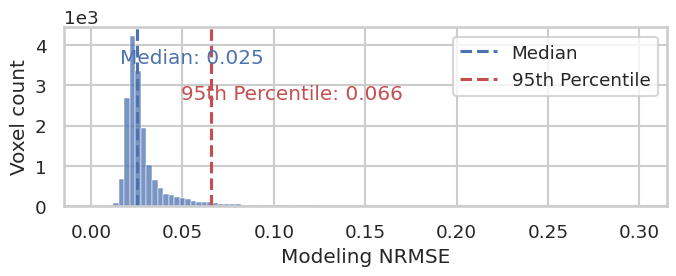

In [11]:
reload(pipelines)
data_feed_mt.slw = 2
vbmf_mt_tissue_param_est, vbmf_err_mt = pipelines.VBMF_MT_run(
    data_feed_mt,
    slices2plot=range(data_feed_mt.shape[1]) if sample else None
    )
utils.fancy_histogram(vbmf_err_mt)

### Reference methods II:  Supervised learning


In [ ]:
from dictionary_methods import dictbased_runner; 
reload(dictbased_runner)

dirname = 'supervised_figs/lhs_mt0'
if not os.path.exists(dirname):
    os.makedirs(dirname)
logger = dictbased_runner.get_logger(f'{dirname}/log.log')

# (!) params appropriate for supervised training (literature and empirically)
data.SlicesFeed.norm_type = 'l2'  # 
net.MyMLP.add_bn = False        
dict_as_slicefeed = dictbased_runner.get_dict()

for ii in range(10):        
    run_dirname = os.path.join(dirname, time.strftime('%B%d_%H%M')) # f"supervised_figs/lhs_mt0/{time.strftime('%B%d_%H%M')}/"
    if not os.path.exists(run_dirname):
        os.mkdir(run_dirname)    
    
    t0 = time.time()
    predictor_mt = dictbased_runner.train_on_dict(dict_as_slicefeed)
    logger.info(f"T(training)={time.time()-t0}sec")

    # --- Evaluate on the training set - the dictionary 
    dict_as_slicefeed.slw = 5 
    estimated_params_synth, reconstituted_signals_synth = infer.infer(dict_as_slicefeed, pool2predict='c', nn_predictor=predictor_mt)
    measured_synth_norm1st = data.SlicesFeed.normalize(dict_as_slicefeed.measured_normed_T, norm_type='first')
    reconstituted_synth_norm1st = data.SlicesFeed.normalize(reconstituted_signals_synth, norm_type='first')
    hvals, hbins = utils.signal_fit_eval_viz(measured_synth_norm1st, reconstituted_synth_norm1st)     
    plt.savefig(run_dirname + f'/err_synth.png')        
    utils.compare_fk_preds(dict_as_slicefeed, estimated_params_synth, pool='c')
    plt.savefig(run_dirname + f'/synth_est_vs_true_scatter.png')        
    err_3d_train = np.linalg.norm(reconstituted_signals_synth - dict_as_slicefeed.measured_normed_T, axis=0, ord=2)
    err_3d_train /= np.linalg.norm(dict_as_slicefeed.measured_normed_T, axis=0, ord=2)                    
    # what happens with the noise augmentation?
    dict_as_slicefeed.add_noise_to_signal = 5e-3 
    estimated_params_synth, reconstituted_signals_synth = infer.infer(dict_as_slicefeed, pool2predict='c', nn_predictor=predictor_mt)
    err_3d_train_noisy = np.linalg.norm(reconstituted_signals_synth - dict_as_slicefeed.measured_normed_T, axis=0, ord=2)
    err_3d_train_noisy /= np.linalg.norm(dict_as_slicefeed.measured_normed_T, axis=0, ord=2)      
            
    # --- Evaluate on the test set - the brain.          
    infer.infer_config.use_cfsskss_inp = False
    estimated_params_brain, reconstituted_signals_brain = infer.infer(data_feed_mt, pool2predict='c', nn_predictor=predictor_mt)
    measured_brain_norm1st = data.SlicesFeed.normalize(data_feed_mt.measured_normed_T, norm_type='first')
    reconstituted_brain_norm1st = data.SlicesFeed.normalize(reconstituted_signals_brain, norm_type='first')
    hvals, hbins = utils.signal_fit_eval_viz(measured_brain_norm1st, reconstituted_brain_norm1st)         
    plt.savefig(run_dirname + '/err_brain.png')
    err_3d_test = np.linalg.norm(reconstituted_brain_norm1st - measured_brain_norm1st, axis=0, ord=2) * data_feed_mt.roi_mask_nans 
    err_3d_test /= np.linalg.norm(data_feed_mt.measured_normed_T, axis=0, ord=2)    
    utils.slice_row_plot(
        estimated_params_brain[f'fc_T'] * data_feed_mt.roi_mask_nans * 100,
        estimated_params_brain[f'kc_T'] * data_feed_mt.roi_mask_nans,
        err_3d_test, fss_lims=[0,30], kss_lims=[0,100], slices=range(data_feed_mt.shape[1]) if sample else None
    )                            
    plt.savefig(run_dirname + '/slices_brain.png')
    
    plt.close('all')
    np.savez_compressed(run_dirname+'/err', err_mt_test=err_3d_test, err_mt_train=err_3d_train, err_3d_train_noisy=err_3d_train_noisy)

0 supervised_figs/lhs_mt0/March08_2323/err.npz
1 supervised_figs/lhs_mt0/March08_2322/err.npz
2 supervised_figs/lhs_mt0/March08_2320/err.npz
3 supervised_figs/lhs_mt0/March08_2319/err.npz
4 supervised_figs/lhs_mt0/March08_2318/err.npz
5 supervised_figs/lhs_mt0/March08_2317/err.npz
6 supervised_figs/lhs_mt0/March08_2315/err.npz
7 supervised_figs/lhs_mt0/March08_2314/err.npz
8 supervised_figs/lhs_mt0/March08_2313/err.npz
9 supervised_figs/lhs_mt0/March08_2311/err.npz


2025-03-08 23:26:27 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/home/alexf/nbmf_public/utils.py:981: UserWarning: 
The palette list has fewer values (2) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=interleaved_data, palette=sns.color_palette(["g", "r"]), showfliers=False)
2025-03-08 23:26:29 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


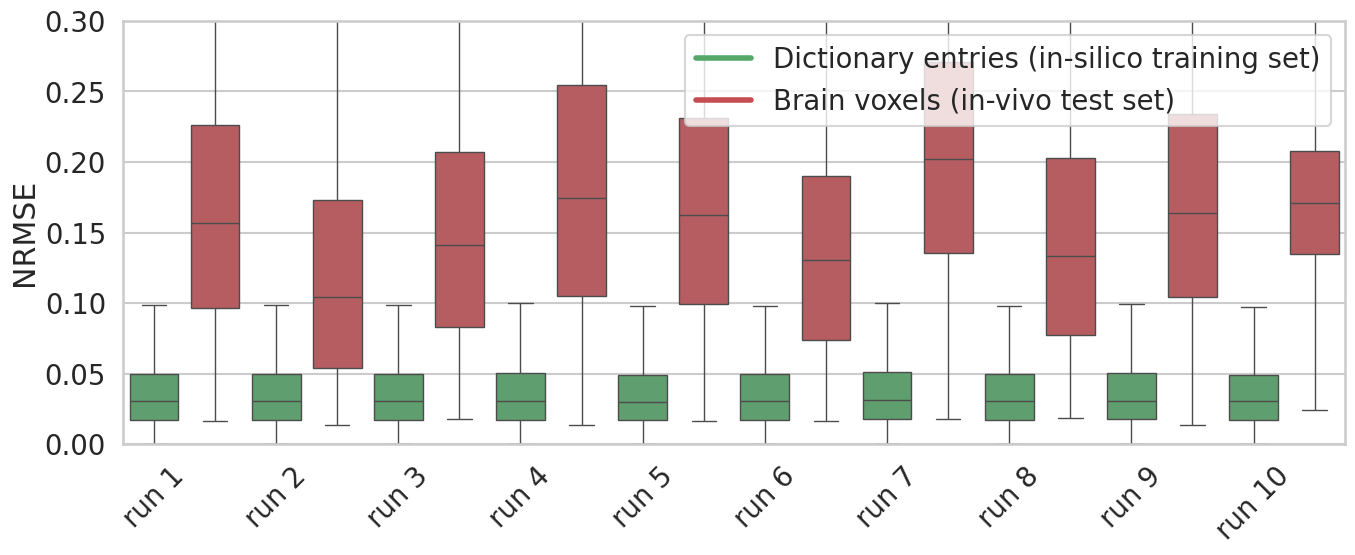

In [ ]:
reload(utils)
maindir = 'supervised_figs/lhs_mt0/'

def prep_err(err):
    return err[err!=0 & ~np.isnan(err)]
errs_self = []
errs_transfer = []    
count = 0 
err_train_key = 'err_3d_train_noisy'  # err_3d_train_noisy
err_test_key = 'err_mt_test' # 'err_3d_train_noisy' # 'err_mt_test' # 'err_mt78'
for ddir in sorted(os.listdir(maindir))[::-1]:
    full_ddir=os.path.join(maindir, ddir)
    if os.path.isdir(full_ddir) and 'err.npz' in os.listdir(full_ddir):
        fname = os.path.join(maindir, ddir, 'err.npz')
        npzf = np.load(fname)
        errs_self.append(prep_err(npzf[err_train_key].flatten()))
        errs_transfer.append(prep_err(npzf[err_test_key].flatten()))
        print(count, fname)
        count += 1
        if count>9:
            break
        
utils.robustness_boxplot_train_test(errs_self, errs_transfer) 